In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

# import balance_configs as configs
import sac_mode_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"
spk_path = os.path.join(base_path, "model_runs")
vc_path = os.path.join(base_path, "vc_runs")

In [4]:
multiplex_base_paths = {"vc": vc_path, "spk": spk_path}
fig_path = os.path.join(base_path, "multiplex_spk_vc_figs")
fig_subdir = None

fig_subdir, exp_names = ("rho100_30n_20tr", {
    "ctrl": {
        "vc": "poissarma_etau3_x0p45w_itau6_x0p8w_ar_0p9_-0p1_rho100_er1p2_ir0p6_30n_20tr",
        "spk": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_30n_20tr",
    },
    # "plex4": {
    #     "vc": "poissarma_etau3_x0p45w_itau6_x0p8w_ar_0p9_-0p1_rho100_er1p2_ir0p6_30n_20tr_plex4",
    #     "spk": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_30n_20tr_plex4",
    # }
})

fig_subdir, exp_names = ("rho100_ctrl_vs_plex", {
    "ctrl": {
        "vc": "poissarma_etau3_x0p45w_itau6_x0p8w_ar_0p9_-0p1_rho100_er1p2_ir0p6_12n_10tr_rho_range",
        "spk": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_12n_10tr_rho_range",
    },
    "plex4": {
        "vc": "poissarma_etau3_x0p45w_itau6_x0p8w_ar_0p9_-0p1_rho100_er1p2_ir0p6_12n_10tr_rho_range_plex4",
        "spk": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_12n_10tr_rho_range_plex4",
    }
})

fig_path = fig_path if fig_subdir is None else os.path.join(fig_path, fig_subdir)
exp_hdfs = {
    exp: {
        k: h5.File(os.path.join(multiplex_base_paths[k], n) + ".h5", "r")
        for k, n in kinds.items()
    }
    for exp, kinds in exp_names.items()
}
d = {
    exp: {k: Workspace(hdf, read_only=True) for k, hdf in kinds.items()}
    for exp, kinds in exp_hdfs.items()
}
os.makedirs(fig_path, exist_ok=True)

# use experiments included in vc since they should be a subset of spk (if they differ)
exps = list(exp_names.keys())
rhos = list(d[exps[0]]["vc"].keys())
idxs = sorted(d[exps[0]]["vc"][rhos[0]].keys())
exp_keys = list(d[exps[0]]["vc"][rhos[0]][idxs[0]].keys())
transmitters = list(d[exps[0]]["vc"][rhos[0]][idxs[0]]["soma"].keys())
n_vc_trials, n_dirs, n_vc_steps = d[exps[0]]["vc"][rhos[0]][idxs[0]]["soma"]["E"].shape
n_spk_trials, n_dirs, n_spk_steps = d[exps[0]]["spk"][rhos[0]][idxs[0]]["soma"]

print("==keys==")
print("rhos:", rhos)
print("idxs:", idxs)
print("exp keys:", exp_keys)
print("vc rec keys:", transmitters)
print("vc rec shape:", (n_vc_trials, n_dirs, n_vc_steps))
print("spk rec shape:")

==keys==
rhos: [0.0, 0.2, 0.4, 0.6, 0.8, 0.85, 0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 1.0]
idxs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
exp keys: ['params', 'sac_net', 'soma', 'syn_locs']
vc rec keys: ['ACH', 'AMPA', 'E', 'GABA']
vc rec shape: (10, 'area', 7501)
spk rec shape:


In [5]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            for exp in d.values():
                for wrk in exp.values():
                    wrk.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [6]:
params = d[exps[0]]["spk"][1.0][0]["params"]
xaxis = np.arange(int(params["tstop"] / params["dt"]) + 1) * params["dt"]
metrics = {exp: ana.get_sac_metrics(d[exp]["spk"]) for exp in exps}

dir_labels = d[exps[0]]["spk"][rhos[0]][idxs[0]]["params"]["dir_labels"][:]
sac_thetas = {
    exp: {k: ana.get_sac_thetas(wrk) for k, wrk in kinds.items()} 
    for exp, kinds in d.items()
}
sac_deltas = {
    exp: {k: ana.get_sac_deltas(ts) for k, ts in kinds.items()} 
    for exp, kinds in sac_thetas.items()
}
print("metrics:", list(metrics[exps[0]][rhos[0]].keys()))

metrics: ['spikes', 'thetas', 'DSis', 'avg_theta', 'avg_DSi']


In [7]:
soma_vm = {
    exp: {
        rho: np.stack([d[exp]["spk"][rho][net]["soma"]["Vm"] for net in idxs], axis=0)
        for rho in rhos
    }
    for exp in exps
}

In [8]:
vc_transmitters = list(d[exps[0]]["vc"][rhos[0]][idxs[0]]["soma"].keys())
vc_params = d[exps[0]]["vc"][rhos[0]][idxs[0]]["params"]
vc_xaxis = np.arange(int(vc_params["tstop"] / vc_params["dt"]) + 1) * vc_params["dt"]

In [9]:
vc_trial_avgs = {
    exp: {
        rho: {
            n: {trans: np.mean(rec, axis=0) for trans, rec in net["soma"].items()}
            for n, net in nets.items()
        }
        for rho, nets in d[exp]["vc"].items()      
    }
    for exp in exps
}
    
vc_net_avgs = {
    exp: {
        rho: {
            trans: np.mean([net[trans] for net in nets.values()], axis=0)
            for trans in vc_transmitters
        }
        for rho, nets in avgs.items()
    }
    for exp, avgs in vc_trial_avgs.items()
}

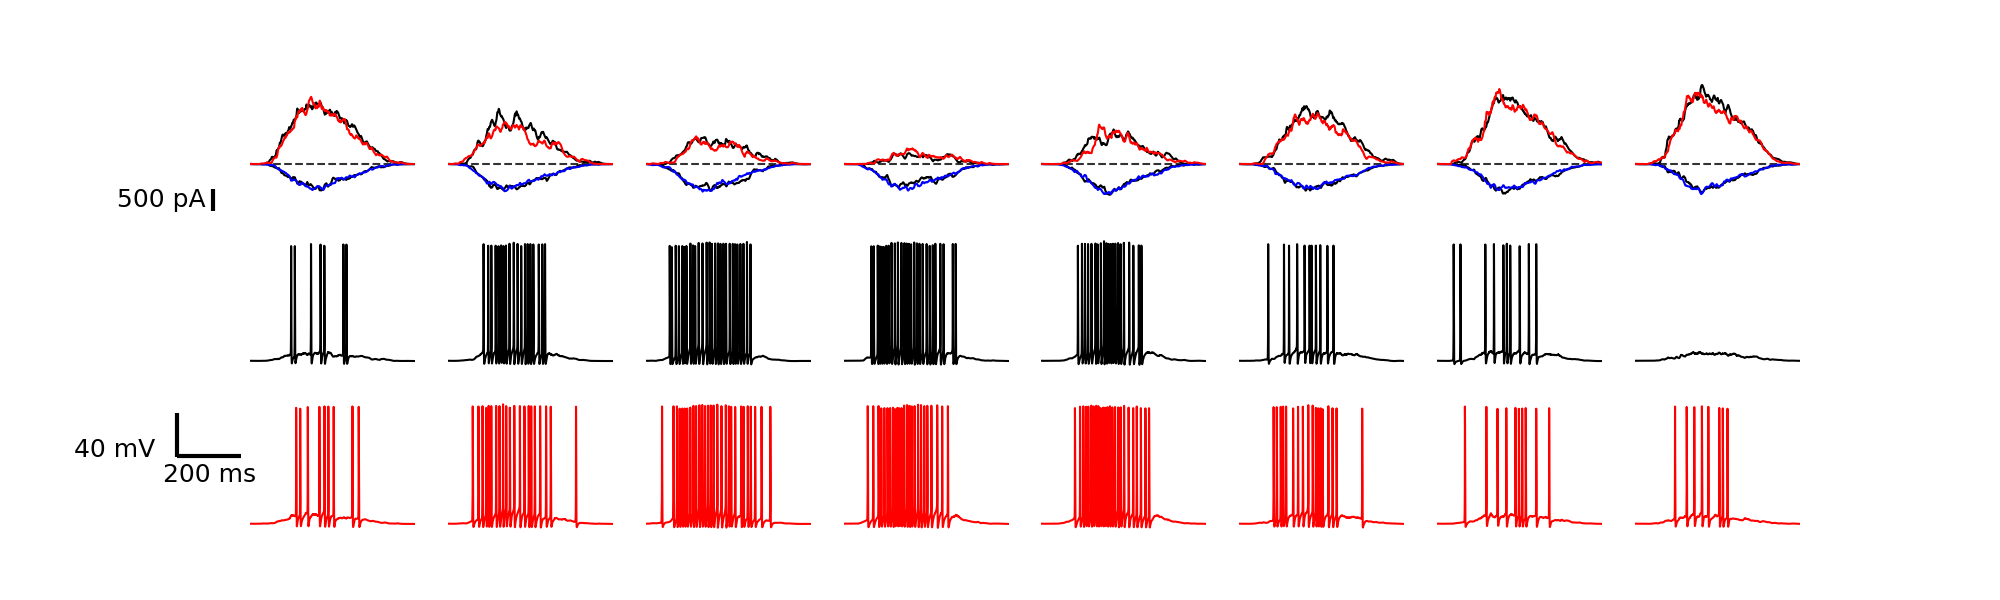

In [16]:
ctrl_lbl = "ctrl"
expr_lbl = "plex4"
row_conds = [
    {"exp": ctrl_lbl, "rho":1.0},
    {"exp": expr_lbl, "rho":1.0},
    # {"exp": ctrl_lbl, "rho":0.0},
]

if len(row_conds) < 0 or len(row_conds) > 2:
    raise ValueError("Only 1 or 2 conditions are supported")

# first row is plotted first in black (usually the correlated/ctrl)
# next row is coloured (usually uncorrelated/plex)
vc_colours = ([("black", "black"), ("blue", "red")]
           if len(row_conds) > 1
           else  [("blue", "red")])
spk_colours = ["black", "red"]

net = 0
trial = 2
vm_t0 = 300
vc_mode = "trial"  # net_avg, trial_avg, or trial (default)
# vc_mode = "trial_avg"
# vc_mode = "net_avg"

if vc_mode == "net_avg":
    get_vc = lambda lbl, rho, trans: vc_net_avgs[lbl][rho][trans]
elif vc_mode == "trial_avg":
    get_vc = lambda lbl, rho, trans: vc_trial_avgs[lbl][rho][net][trans]
else:
    get_vc = lambda lbl, rho, trans: d[lbl]["vc"][rho][net]["soma"][trans][trial]

trial_vm_vc_fig, trial_vm_vc_ax = plt.subplots(
    1 + len(row_conds), len(dir_labels), sharex=True, sharey="row", figsize=(20, 6))

for i, ax in enumerate(trial_vm_vc_ax[0]):
    ax.plot([vc_xaxis[0], vc_xaxis[-1]], [0., 0.], c="black", linestyle="--", alpha=0.8)  # 0mV line
    for j, row in enumerate(row_conds):
        e_col, i_col = vc_colours[j]
        ax.plot(vc_xaxis, get_vc(row["exp"], row["rho"], "E")[i], c=e_col)
        ax.plot(vc_xaxis, get_vc(row["exp"], row["rho"], "GABA")[i], c=i_col)
    ax.patch.set_alpha(0)

vc_sb = add_scalebar(
    trial_vm_vc_ax[0, 0], 
    matchx=False, 
    matchy=False, 
    # sizey=1.5, 
    # labely="1.5 nA",
    sizey=0.5, 
    labely="500 pA",
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(165, 400),
    textprops={"fontsize": 18},
)

vm_pts = d["ctrl"]["spk"][1.0][net]["soma"]["Vm"].shape[-1] 
vm_xaxis = np.linspace(0, vm_pts * d["ctrl"]["spk"][row_conds[0]["rho"]][net]["params"]["dt"], vm_pts)

for i, row in enumerate(row_conds): 
    clr = spk_colours[i]
    for j in range(len(dir_labels)):
        trial_vm_vc_ax[i + 1, j].plot(
            vm_xaxis[vm_t0:], d[row["exp"]]["spk"][row["rho"]][net]["soma"]["Vm"][trial, j, vm_t0:], c=clr)
        trial_vm_vc_ax[i + 1, j].patch.set_alpha(0)

sizex = 200
sizey = 40
vm_sb = add_scalebar(
    trial_vm_vc_ax[1, 0], 
    matchx=False, 
    matchy=False, 
    sizex=sizex, 
    sizey=sizey, 
    labelx="%i ms" % sizex,
    labely="%i mV" % sizey,
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(165, 150),
    textprops={"fontsize": 18},
)

clean_axes(trial_vm_vc_ax, remove_spines=["left", "right", "top", "bottom"])
trial_vm_vc_ax[0, 0].set_ylim(-1, 2.1)
trial_vm_vc_ax[0, 0].set_xlim(vm_xaxis[vm_t0], vm_xaxis[-1])

rho_tag = lambda r: "rho" +  ("%.2f" % r).replace(".", "p")
if len(row_conds) == 1:
    prefix = "vm_%s_%s" % (row_conds[0], rho_tag(row_conds[1]))
elif len(row_conds) == 2:
    k1, k2 = (cond["exp"] for cond in row_conds)
    prefix = "vm_%s_r%s_%s_r%s" % (k1, rho_tag(row_conds[0]["rho"]), k2, rho_tag(row_conds[1]["rho"]))
    
if vc_mode == "trial":
    name = "%s_net%i_trial%i" % (prefix, net, trial)
elif vc_mode == "trial_avg":
    name = "%s_net%i_avg" % (prefix, net)
elif vc_mode == "net_avg":
    name = "%s_all_net_avg" % prefix
for ext in [".png", ".svg"]:
    trial_vm_vc_fig.savefig(os.path.join(fig_path, name) + ext, transparent=True)

In [11]:
close_button()